<a href="https://colab.research.google.com/github/chuk-yong/Neo4j-Company-Show-Case/blob/main/Neo4j_Company_Showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Relational Graph Using Neo4j and Python
Create a Neo4j sandbox, connect to it and populate it with the nodes, relationship and properties given.

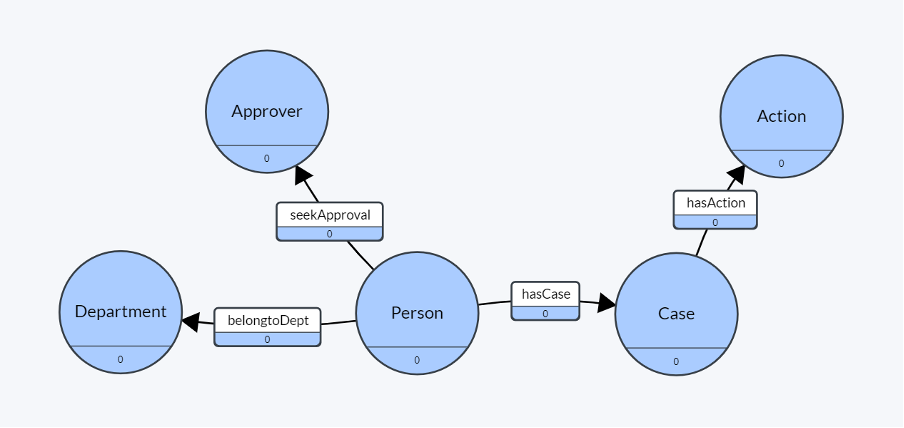

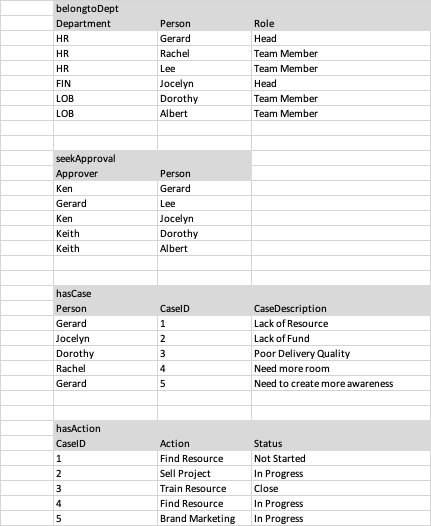

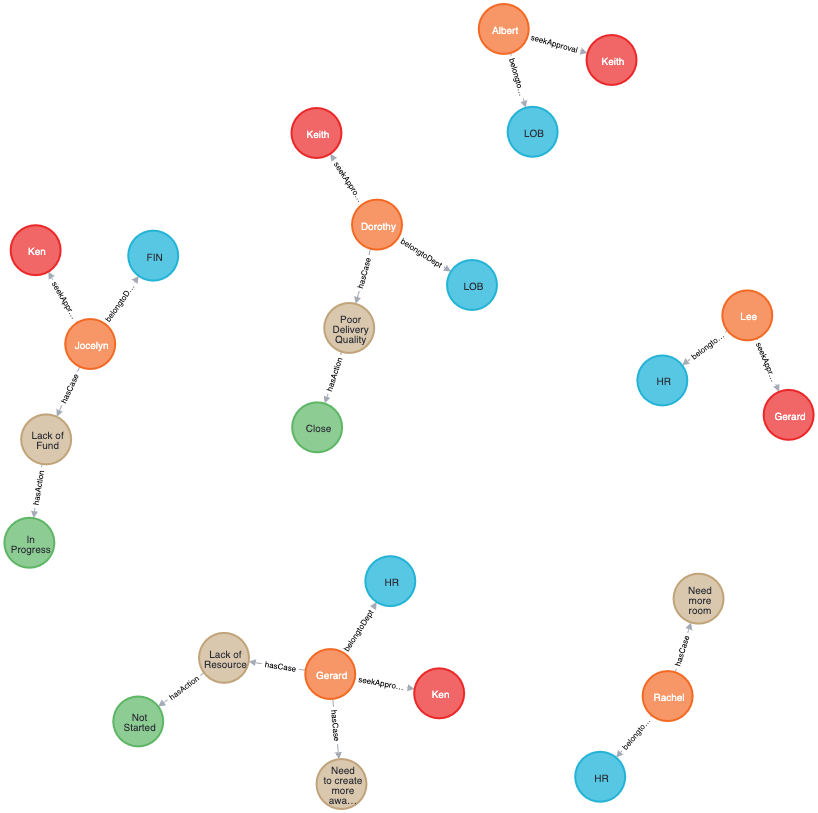

In [1]:
!pip install neo4j

In [2]:
from neo4j import GraphDatabase

In [4]:
# In Neo4j sandbox, make sure to select a black database.
# Create connection and session
conn = GraphDatabase.driver(uri="bolt://34.201.210.71:7687", auth=("neo4j","decay-braid-guidance"))
session = conn.session()

In [5]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/Dept-Person-Role.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Department  6 non-null      object
 1   Person      6 non-null      object
 2   Role        6 non-null      object
dtypes: object(3)
memory usage: 272.0+ bytes


In [7]:
#C1='CREATE (p:Person {[Name:df[row.Index]["Person"], Role=df[row.Index]["Role]})-[:belongtoDept]->(d:Department [Name:df[row.Index]["Department])' # use single quote
for row in df.itertuples():
  C1='CREATE (p:Person {Name:"' + row.Person +'", Role:"' + row.Role + '"})-[:belongtoDept]->(d:Department {Name:"' + row.Department +'"})'
  print(C1)
  session.run(C1)

CREATE (p:Person {Name:"Gerard", Role:"Head"})-[:belongtoDept]->(d:Department {Name:"HR"})
CREATE (p:Person {Name:"Rachel", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"HR"})
CREATE (p:Person {Name:"Lee", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"HR"})
CREATE (p:Person {Name:"Jocelyn", Role:"Head"})-[:belongtoDept]->(d:Department {Name:"FIN"})
CREATE (p:Person {Name:"Dorothy", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"LOB"})
CREATE (p:Person {Name:"Albert", Role:"Team Member"})-[:belongtoDept]->(d:Department {Name:"LOB"})


In [8]:
# approval
app = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/Approver-Person.csv")
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Approver  5 non-null      object
 1   Person    5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


In [12]:
def approval_of(tx, name, approver):
    tx.run("MATCH (a:Person) WHERE a.Name = $name "
           "MERGE (a)-[:seekApproval]->(:Approver {Name: $approver})",
           name=name, approver=approver)

for row in app.itertuples():
  print(row.Person, row.Approver)
  with session as sess:
      sess.write_transaction(approval_of, row.Person, row.Approver)

Gerard Ken
Lee Gerard
Jocelyn Ken
Dorothy Keith
Albert Keith


In [13]:
# has case
case = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/Person-CaseID-Desc.csv")
case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Person           5 non-null      object
 1   CaseID           5 non-null      int64 
 2   CaseDescription  5 non-null      object
dtypes: int64(1), object(2)
memory usage: 248.0+ bytes


In [22]:
def has_case(tx, name, caseID, desc):
    tx.run("MATCH (a:Person) WHERE a.Name = $name "
           "MERGE (a)-[:hasCase]->(:Case {CaseID: $caseID,CaseDescription: $desc})",
           name=name, caseID=caseID, desc=desc)

for row in case.itertuples():
  with session as sess:
    sess.write_transaction(has_case, row.Person, row.CaseID, row.CaseDescription)

In [23]:
# has action
action = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Neo4j/CaseID-Action-Status.csv")
action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CaseID  5 non-null      int64 
 1   Action  5 non-null      object
 2   Status  5 non-null      object
dtypes: int64(1), object(2)
memory usage: 248.0+ bytes


In [26]:
def has_action(tx, case, action, status):
    tx.run("MATCH (a:Case) WHERE a.CaseID = $case "
           "MERGE (a)-[:hasAction]->(:Action {Action: $action, Status: $status})",
           case=case, action=action, status=status)

for row in action.itertuples():
  with session as sess:
    sess.write_transaction(has_action, row.CaseID, row.Action, row.Status)

In [ ]:
# Query headcount.  How many people are there in LOB department?
q = 'match (n:Department) where n.Name = "LOB" return count(n)'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results)

In [46]:
# Query case count by department. How many case load are there for HR department?
q = 'match ()<-[:hasCase]-(n:Person)-[:belongtoDept]->(Department {Name:"HR"}) return count(distinct n)'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results)

[{'count(distinct n)': 2}]


In [49]:
# approval office.  Who is Rachel's Boss?
q = 'match (Person {Name:"Rachel"})-[:seekApproval]->(a:Approver) return a.Name'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results) # Rachel has no approver

[]
[]


In [55]:
q = 'match (Person {Name:"Rachel"})-[:belongtoDept]->(d:Department) with d.Name as dept match (p:Person {Role:"Head"})-[belongtoDept]->(Department {Name:dept}) return p.Name'
nodes = session.run(q)
results = [record for record in nodes.data()]
print(results)

[{'p.Name': 'Gerard'}]


In [65]:
# q = "MATCH (p:Person)-[:belongtoDept]->(Department {Name:'HR'}) RETURN p.Name"
# nodes = session.run(q)
# results = [record for record in nodes.data()]
# print(results)

def count_action(tx, dept):
    tx.run("MATCH (p:Person)-[:belongtoDept]->(Department {Name:'HR'})"
            "RETURN p.Name").single().value()

with session as sess:
  nodes = sess.write_transaction(count_action, "HR")
  results = [record for record in nodes.data()]
  print(results)

SyntaxError: ignored

In [ ]:
# Action count
def count_action(tx, dept):
    tx.run("MATCH (p:Person)-[:belongtoDept]->(Department {Name:$dept})"
            "WITH p.Name as name"
            "Match (Person {Name:name})-[:hasCase]->(c:Case)"
            "WITH c.CaseID as id"
            "Match (Case {CaseID:id})-[:hasAction]->(act:Action)"
            "WITH apoc.agg.maxItems(act, act.Action) AS result"
            "RETURN result.items AS action result.value AS count"
           "MERGE (a)-[:hasAction]->(:Action {Action: $action, Status: $status})",
           dept=dept)

with session as sess:
  sess.write_transaction(count_action, "HR")